# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Chaves, Noelia
- Frau, Johanna

### Mentora:

- Dal Lago, Virginia

### Práctico: Introducción al aprendizaje automático

## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.




## Objetivos generales

  

## Objetivos específicos
* Emplear y calcular la performance de un modelo de aprendizaje supervisado de tipo             support vector machine, separando para ello en dos clases: envíos rápidos (demoran            menos de 3 días) y lentos (demoran 3 o más días). ¿Existen outliers? ¿Son los datos                linealmente separables? Si no lo son, ¿qué kernel creen se podría emplear para             realizar la proyección? 
* En la problemática propuesta, podemos dividir la experiencia del usuario en tres            situaciones diferentes: el envío llegó antes de lo prometido, el día prometido o             después del día prometido. Definir una o más métricas que nos permitan determinar             la performance de los modelos desarrollados considerando las tres posibles          experiencias de usuario de interés.  
* Determinar, desarrollar y calcular la performance (según las métricas definidas en el            punto anterior) de un modelo de aprendizaje supervisado de tipo ensemble de            modelos (considerando todas las clases posibles). ¿Cuál es la diferencia con los            modelos más sencillos del práctico anterior? ¿Cómo es la performance en este            caso? ¿Cómo creen que puede incrementarse aún más la performance utilizando           este tipo de modelos?
* Elegir las dos features que considere más relevante y desarrollar un modelo de             clustering (sin utilizar la información del target, i.e., ​shipment_days ​ ).  
* Realizar una visualización de los diferentes clusters.  ¿Cómo son los tamaños relativos?  ¿Parecen adecuados para el problema de interés?  ¿Representan a todas las clases?  ¿Qué medida podemos utilizar para inspeccionar el contenido de los clusters?           Aplicarla al problema y comentar el resultado obtenido.  ¿Qué modificaciones deberíamos llevar a cabo para que los clusters sean más            representativos del problema de interés? 
* Repetir el análisis anterior empleando en el modelo de clustering un número            mayor de clusters (que difiera del anterior en al menos 3). ¿Qué diferencias             observa en ambos casos? 
* Utilizando todos los features y el número de clusters que considere mejor para el              problema de interés, desarrollar un modelo de clustering. ​Calcular accuracy y la            performance según las métricas definidas en el segundo punto. ¿Cómo es la            performance comparada a la del modelo de aprendizaje supervisado? Comente          sobre cuál modelo es mejor y por qué. 
* Emplear un embedding sobre las features seleccionadas (por ejemplo, PCA) y           emplear el mismo modelo de clustering desarrollado en el punto anterior. ¿Cómo se             modifican las métricas? ¿Y el tiempo de entrenamiento? Comente sobre las ventajas            y/o desventajas de aplicar el embedding. 


## Desarrollo del trabajo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
import sklearn

from datetime import timedelta
from IPython.display import HTML
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import preprocessing
from sklearn import tree
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures

from sklearn.svm import SVC


### Lectura y análisis inicial de los datos

In [ ]:
url = "https://raw.githubusercontent.com/cnoeliachaves/csv/master/dataset_sample_corrected.csv"

dataset = pandas.read_csv(url, dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
dataset.shape

(500000, 12)

In [ ]:
dataset.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        500000 non-null object
sender_zipcode      500000 non-null int64
receiver_state      500000 non-null object
receiver_zipcode    500000 non-null int64
shipment_type       500000 non-null object
quantity            500000 non-null int64
service             500000 non-null int64
status              500000 non-null object
date_created        500000 non-null datetime64[ns]
date_sent           499971 non-null datetime64[ns]
date_visit          499398 non-null datetime64[ns]
shipment_days       499398 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 45.8+ MB


In [ ]:
np.random.seed(1234) #con propositos de reproducibilidad
#dataset.sample(10)

### Limpieza de datos

En esta sección retomaremos algunos puntos del práctico anterior con el objetivo de limpiar nuestro dataset.

#### Shipment day anómalos 

En primer lugar, eliminaremos los valores de shipment days negativos.

In [ ]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    return dataset[mask] 

In [ ]:
dataset_clean = clean_shipment_days(dataset)

####Fechas anómalas

En el análisis realizado en el práctico anterior de las 3 variables con información de fechas y horas encontramos que la variable date_created cuenta con valores que caen fuera del intervalo temporal considerado y que todos ellos se encuentran ubicados en el mes de Junio de 2019. Luego de haber realizado una inspección de esta información anómala llegamos a la conclusión que los mismos podrían deberse a un error en el proceso de carga y que en realidad son datos de Enero de 2019. 

Siguiendo esta idea decidimos en este momento subsanar este posible error de carga haciendo que la información de la variable date_created correspondiente al mes de Junio de 2019 sea ahora del mes de Enero de 2019.

In [ ]:
date_created_junio = dataset_clean[dataset_clean['date_created'].map(lambda x: x.month) == 6]
#date_created_junio

In [ ]:
date_created_junio = dataset_clean['date_created'].map(lambda x: 
                                                       x+timedelta(days=-151) 
                                                       if x.month==6 else x)

In [ ]:
dataset_clean.loc[:,'date_created'] = date_created_junio

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
dataset_clean['date_created'].dt.month.unique()

array([ 3,  2,  1,  4, 12, 10, 11])

In [ ]:
dataset_clean.describe(include='datetime64')

,date_created,date_sent,date_visit
count,499350,499350,499350
unique,124,81276,55668
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20424,113,621
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-04-29 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


En el describe de arriba, podemos ver que la última fecha de creación es posterior a la última fecha de data_sent como date_visit, pero consideramos que dichos datos son correctos, ya que no contamos con el completo dataset.

#### Valores nulos

Veamos cuantos valores nulos tenemos

In [ ]:
null_values_count = dataset_clean.isnull().sum()
null_values_count[null_values_count > 0]

Series([], dtype: int64)

Podemos ver que no tenemos valores nulos en el dataset.

#### Limpieza de las fechas anomálas

Ahora limpiaremos el dataset sacando todas aquellas fechas que no se siguen en la línea temporal. 

In [ ]:
date_created_before_date_sent = dataset_clean.date_created < dataset_clean.date_sent #Filtramos date_created menores que date_sent

date_sent_before_date_visit = dataset_clean.date_sent < dataset_clean.date_visit #Filtramos date_sent menores que date_visit

date_created_before_date_visit = dataset_clean.date_created < dataset_clean.date_visit #Filtramos date_created menores que date_visit


In [ ]:
dataset_clean = dataset_clean[date_created_before_date_sent].dropna() # solo fechas de creacion antes de la fecha de envio
dataset_clean = dataset_clean[date_created_before_date_visit].dropna()# solo fechas de creacion antes de la fecha de visita
dataset_clean = dataset_clean[date_sent_before_date_visit].dropna()# solo fechas de envios antes de la fecha de visita
dataset_clean.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
193186,SP,13026,RJ,24435,express,1,0,done,2019-03-10,2019-03-11 11:25:00,2019-03-18 11:26:00,5.0
245787,SP,8599,SP,13420,express,1,0,done,2019-03-16,2019-03-18 17:25:00,2019-03-20 15:42:00,2.0
399104,SP,4905,RS,94450,standard,1,1,done,2019-03-02,2019-03-04 17:52:00,2019-03-20 11:01:00,9.0
22402,SP,4744,PR,85862,standard,1,1,done,2019-03-03,2019-03-07 16:51:00,2019-03-19 12:12:00,8.0
138938,SP,7176,RS,95660,standard,1,2,done,2019-03-05,2019-03-06 23:36:07,2019-03-12 07:45:00,3.0


### La importancia de predecir el valor de la variable shipment_days

Uno de los objetivos principales del análisis propuesto en esta mentoría es predecir (dar un número aproximado de días hábiles) el tiempo entre que se despacha del correo hasta que el mismo llega a la casa del comprador. 

Es decir, queremos predecir el feature shipment_days.

Por lo tanto este sería el target de un algoritmo de aprendizaje automático. Si bien este feature originalmente es información de tipo numérica en el práctico anterior utilizamos enconding para convertirla en una variable categórica. Así, esto nos da la posibilidad de trabajar con diferentes modelos de aprendizaje automático utilizando el mismo feature como target pero en sus diferentes versiones.

Frente a este problema consideramos que el estado de Brasil que recibe el envío (receiver_state) es un feature importante a tener en cuenta (mientras más lejos esté de San Pablo probablemente demore más) y probablemente también el código postal de dicho estado (receiver_zipcode). Por otro lado, el tipo de correo (service) también puede ser una variable importante a tener en cuenta porque la calidad de servicio impactará directamente en los días que tarda en llegar el pedido.



In [ ]:
dataset_clean.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
470586,SP,2510,SP,2435,express,1,5,done,2019-02-28,2019-03-01 22:39:58,2019-03-07 07:19:11,1.0
399813,SP,13306,SC,89600,standard,1,1,done,2019-03-12,2019-03-15 17:16:00,2019-03-28 13:34:00,9.0
371289,SP,11700,SP,11250,express,1,0,done,2019-03-05,2019-03-11 17:07:00,2019-03-18 18:14:00,5.0
255762,SP,14030,MG,30330,standard,1,1,done,2019-02-18,2019-02-19 19:08:00,2019-02-28 14:29:00,7.0
406847,SP,3410,SP,14200,express,1,0,done,2019-02-26,2019-02-27 12:39:00,2019-03-11 16:34:00,5.0


In [ ]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496954 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        496954 non-null object
sender_zipcode      496954 non-null int64
receiver_state      496954 non-null object
receiver_zipcode    496954 non-null int64
shipment_type       496954 non-null object
quantity            496954 non-null int64
service             496954 non-null int64
status              496954 non-null object
date_created        496954 non-null datetime64[ns]
date_sent           496954 non-null datetime64[ns]
date_visit          496954 non-null datetime64[ns]
shipment_days       496954 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 49.3+ MB


Luego de haber limpiado nuestro dataset observamos que contamos con 496954 filas con información, es decir la limpieza solo afectó aproximadamente al 1% de los datos originales.



### Codifiquemos receiver_state, para poder usarlo porque necesitamos que sea una variable numérica:

In [ ]:
receiver_state_le = 'receiver_state'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(dataset_clean[receiver_state_le])

LabelEncoder()

In [ ]:
dataset_clean['receiver_state_le'] = le.transform(dataset_clean[receiver_state_le]) 
dataset_clean.sample()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le
45619,SP,7600,SP,14940,express,2,0,done,2019-03-12,2019-03-13 13:52:00,2019-03-19 16:30:00,4.0,25


In [ ]:
dataset_clean['receiver_state_le'].unique()

array([25, 14, 18,  3, 22, 10,  6, 12, 17,  8,  7, 23, 26,  4, 16, 11, 13,
        0, 15,  9, 19,  5,  1, 20,  2, 24, 21])

In [ ]:
dataset_clean['receiver_state_le'].groupby(
                          [dataset_clean['receiver_state_le']]
                           ).agg({'count'})

,count
receiver_state_le,
0,836
1,2984
2,1954
3,786
4,21096
5,5227
6,10836
7,10066
8,13241


### Separación en el conjunto de entrenamiento y evaluación 

A continuación analizamos las variables de fechas para poder hacer la separación de los datos.

In [ ]:
# creamos una nueva columna donde date_created solo considera las fechas
dataset_clean['date_created_only_date'] = dataset_clean['date_created'].dt.date

In [ ]:
# creamos una nueva columna donde date_visit solo considera las fechas
dataset_clean['date_visit_only_date'] = dataset_clean['date_visit'].dt.date

In [ ]:
dataset_clean.sort_values(by=['date_visit_only_date']) 

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le,date_created_only_date,date_visit_only_date
29645,SP,9550,ES,29170,standard,3,1,done,2019-01-22,2019-01-28 07:20:00,2019-02-25 15:29:00,20.0,7,2019-01-22,2019-02-25
23725,SP,15410,RJ,28633,standard,1,1,done,2019-02-02,2019-02-05 12:29:00,2019-02-25 15:20:00,14.0,18,2019-02-02,2019-02-25
327308,SP,3401,MG,37420,standard,1,1,done,2019-02-05,2019-02-06 15:36:00,2019-02-25 09:58:00,13.0,10,2019-02-05,2019-02-25
87974,SP,1536,PE,54240,standard,1,4,done,2019-01-29,2019-02-03 07:58:02,2019-02-25 14:28:00,15.0,15,2019-01-29,2019-02-25
192809,SP,1212,SC,88356,standard,1,1,done,2019-01-22,2019-01-23 11:30:00,2019-02-25 12:44:00,22.0,23,2019-01-22,2019-02-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50700,SP,8275,PE,52120,standard,1,1,done,2019-02-27,2019-03-04 16:54:00,2019-04-02 10:19:00,18.0,15,2019-02-27,2019-04-02
264185,SP,14780,RS,96407,standard,1,1,done,2019-02-26,2019-02-26 14:15:00,2019-04-02 15:35:00,22.0,22,2019-02-26,2019-04-02
274961,SP,4433,PE,53525,standard,1,1,done,2019-02-20,2019-02-21 10:27:00,2019-04-02 12:33:00,25.0,15,2019-02-20,2019-04-02
467449,SP,3633,PE,52160,standard,1,1,done,2019-02-18,2019-02-20 07:30:00,2019-04-02 09:49:00,26.0,15,2019-02-18,2019-04-02


Según podemos observar en los cálculos de arriba la variable date_visit abarca desde el 25-02-2019 al 02-04-2019.

Veamos ahora como se distribuyen estos datos dentro de este intervalo temporal.

In [ ]:
dataset_clean['date_visit'].groupby(
                          [dataset_clean['date_visit'].dt.month.rename('month'), 
                           dataset_clean['date_visit'].dt.day.rename('day')]
                           ).agg({'count'})

count
month day       
2     25    2021
      26    1617
      27    2661
      28   21658
3     1    20906
      7    31894
      8    38442
      11   35573
      12   36365
      13   25702
      14   25169
      15   24035
      18   31013
      19   24466
      20   25683
      21   23490
      22   22772
      25   28824
      26   23528
      27   24537
      28   22123
      29    3119
4     1     1309
      2       47

In [ ]:
dataset_clean['date_visit'].groupby([dataset_clean['date_visit'].dt.month.rename('month')]).agg({'count'})

,count
month,
2,27957
3,467641
4,1356


Dada la característica de nuestro problema (estimar una cantidad de días) y al estar trabajando con variables de tipo fecha debemos ser cuidadosas al momento de elegir nuestro conjunto de entrenamiento y validación de manera que le den sentido al problema y que al mismo tiempo representen el 70% y 30% respectivamente de los datos. Es decir, la partición debe estar basada en el hecho de que date_created, date_sent y date_visit se siguen una a la otra en la línea temporal. Por lo tanto, los datos a entrenar deben elegirse hasta un cierto día de la variable date_visit y validarse con datos de date_created a partir de esa fecha.

Considerando que nuestro dataset cuenta en este momento con 496954 entradas, el 70% del mismo representa aproximadamente 345000 entradas. Así, de acuerdo a la distribución mostrada arriba si entrenamos nuestro modelo con datos de la variable date_visit hasta el 20 de marzo podriamos llegar a cubrir este porcentaje. En resumen vamos a entrenar con datos que llegaron a destino (este es el por qué se mira data_visit) y vamos a validar con datos cuyas compras se crearon (date_created) después de esa fecha.

A continuación se realizan los cálculos que permitirán hacer la partición de los datos de acuerdo al criterio antes mencionado.

Mask1 la vamos a usar para hacer el filtrado de los datos para el entrenamiento y mask2 la vamos a usar para hacer el filtrado de los datos para la validacion.

In [ ]:
mask1 = dataset_clean['date_visit']<=pandas.to_datetime('2019-03-20')
mask2 = dataset_clean['date_created']>pandas.to_datetime('2019-03-20')

Eliminamos los valores que cumplen con las dos condiciones simultáneamente.

In [ ]:
dataset_clean.drop(dataset_clean[mask1&mask2].index, inplace = True)

In [ ]:
df_train = dataset_clean.loc[mask1]

In [ ]:
df_test = dataset_clean.loc[mask2]

In [ ]:
X_train = df_train[['receiver_state_le','service']]

In [ ]:
y_train = df_train[['shipment_days']]

In [ ]:
X_test = df_test[['receiver_state_le','service']]

In [ ]:
y_test = df_test[['shipment_days']]

Necesitamos que el target sea un valor entero, por ende convertimos shipment_day en entero:

In [ ]:
shipment_days =  y_train['shipment_days'].astype(int)
shipment_days_byclass = [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if 0==row:
        shipment_days_byclass[line] = 0
    elif 1==row:
        shipment_days_byclass[line] = 1     
    elif 2==row:
        shipment_days_byclass[line] = 2
    elif 3==row:
        shipment_days_byclass[line] = 3
    elif 4==row:
        shipment_days_byclass[line] = 4
    elif 5==row:
        shipment_days_byclass[line] = 5        
    else:
        shipment_days_byclass[line] = 6        

In [ ]:
y_train.loc[:,('shipment_days_byclass')] = shipment_days_byclass
y_train['shipment_days_byclass'].head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0    5
1    5
2    4
3    2
4    6
Name: shipment_days_byclass, dtype: int64

Hay que hacer lo mismo para los valores de validación:

In [ ]:
shipment_days_test = y_test['shipment_days'].astype(int)
shipment_days_byclass_test = [None] * len(shipment_days_test)
for line,row in enumerate(shipment_days_test):
    if 0==row:
        shipment_days_byclass_test[line] = 0
    elif 1==row:
        shipment_days_byclass_test[line] = 1     
    elif 2==row:
        shipment_days_byclass_test[line] = 2
    elif 3==row:
        shipment_days_byclass_test[line] = 3
    elif 4==row:
        shipment_days_byclass_test[line] = 4
    elif 5==row:
        shipment_days_byclass_test[line] = 5        
    else:
        shipment_days_byclass_test[line] = 6

In [ ]:
y_test['shipment_days_byclass'] = shipment_days_byclass_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
y_test['shipment_days_byclass'].values

array([1, 0, 3, ..., 3, 1, 2])

In [ ]:
y_train['shipment_days_byclass'].values

array([5, 5, 4, ..., 2, 2, 6])

In [ ]:
X_train.head()

,receiver_state_le,service
0,25,1
1,14,1
2,18,2
3,25,2
4,3,1


In [ ]:
#col = y_test['shipment_days_byclass'].map({1:'r', 0:'b'})# ver si se usa esto
#col

In [ ]:
clf = sklearn.svm.LinearSVC()
clf.fit(X_train.head(3000), y_train['shipment_days_byclass'].head(3000))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) #concatena
    #print(Z)
    Z = Z.reshape(xx.shape) #le vuelve a poner x
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

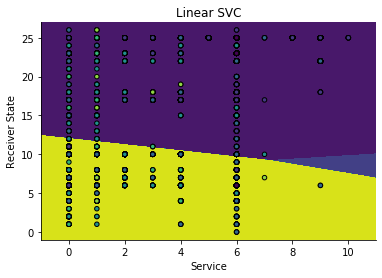

In [ ]:
xx, yy = make_meshgrid(X_train['service'].head(3000).values, X_train['receiver_state_le'].head(3000).values)
fig, sub = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
U = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = U.reshape(xx.shape)

out = sub.contourf(xx, yy, Z)
sub.scatter(X_test['service'].values, X_test['receiver_state_le'].values , c=y_test['shipment_days_byclass'].values, s=20, edgecolors='k')
sub.set_xlabel('Service')
sub.set_ylabel('Receiver State')
plt.title("Linear SVC")
sns.despine()

In [ ]:
X_test.shape

(32524, 2)

In [ ]:
y_test.shape

(32524, 2)

In [ ]:
import os.path
if not os.path.exists("./diplodatos"):
  !git clone https://github.com/cnoeliachaves/diplodatos.git

Cloning into 'diplodatos'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 504 (delta 33), reused 138 (delta 20), pack-reused 349
Receiving objects: 100% (504/504), 139.17 MiB | 12.90 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Checking out files: 100% (288/288), done.


In [ ]:
from diplodatos.ml.visualization import plot_confusion_matrix, plot_learning_curve

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print("LSVC Accuracy :", accuracy_score(y_test['shipment_days_byclass'].head(3000), U[:y_test['shipment_days_byclass'].head(3000).shape[0]])*100)

LSVC Accuracy : 0.03333333333333333


El accuray que obtenemos es muy bajo, por lo que podemos ver que los datos no son linealmente separables.

In [ ]:
y_test.shape[0]

32524

Computemos la matriz de confusión para ver los outliers:

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test['shipment_days_byclass'], U[:y_test.shape[0]])
cnf_matrix

array([[    0,     0,     0,     0,     0,     0,  1826],
       [    0,     0,     0,     0,     0,     0, 16445],
       [    0,     0,     0,     0,     0,     0,  8988],
       [    0,     0,     0,     0,     0,     0,  3774],
       [    0,     0,     0,     0,     0,     0,  1195],
       [    0,     0,     0,     0,     0,     0,   285],
       [    0,     0,     0,     0,     0,     0,    11]])

In [ ]:
class_names={'0','1','2','3','4','5','6'}

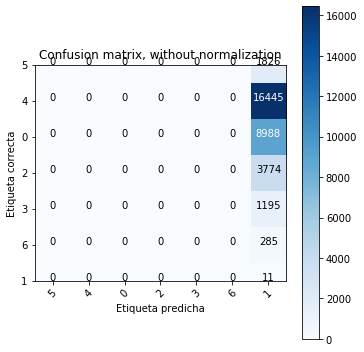

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plot_confusion_matrix(cnf_matrix,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

Se predijieron 285 casos como del estado 2, cuando en realidad corresponden al estado 1. Idem con los demás valores.

Existen varios kernels, entre ellos estan: sigmoid, rbf, y poly. Creemos que el kernel que se podria usar para realizar la proyeccion seria poly por la forma de los datos que podemos ver en la figura donde se ploteo LinearSVC.

In [ ]:
clf = sklearn.svm.SVC(kernel="poly", gamma="auto")
clf.fit(X_train.head(1000), y_train['shipment_days_byclass'].head(1000));#bajarle a la cantidad de entrenamiento

Text(0.5, 1.0, 'Polinomial')

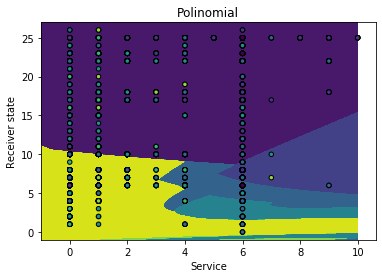

In [ ]:
xx, yy = make_meshgrid(X_train['service'].head(1000).values, X_train['receiver_state_le'].head(1000).values)
fig, sub = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
U = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = U.reshape(xx.shape)

out = sub.contourf(xx, yy, Z)
sub.scatter(X_test['service'].values, X_test['receiver_state_le'].values , c=y_test['shipment_days_byclass'].values, s=20, edgecolors='k')
sub.set_xlabel('Service')
sub.set_ylabel('Receiver state')
plt.title("Polinomial")

Calculemos el accuracy:

In [ ]:
print("LSVC Accuracy :", accuracy_score(y_test['shipment_days_byclass'].head(1000), U[:y_test['shipment_days_byclass'].head(1000).shape[0]])*100)

LSVC Accuracy : 5.6000000000000005


Mejora un poco, pero no hasta llegar a un valor esperado cercano a 1.

En la problemática propuesta, podemos dividir la experiencia del usuario en tres            situaciones diferentes: el envío llegó antes de lo prometido, el día prometido o             después del día prometido. Definir una o más métricas que nos permitan determinar             la performance de los modelos desarrollados considerando las tres posibles          experiencias de usuario de interés.

Podemos definir 3 métricas dónde:
1. Cuente la cantidad de envíos que llegaron antes de lo prometido sobre el total de envíos.
2. Cuente la cantidad de envíos que llegaron el día prometido sobre el total de envíos.
3. Cuente la cantidad de envíos que llegaron después de lo prometido sobre el total de envíos.

A continuación usaremos un método de ensembling, tratando de usar las métricas definidas arriba:

In [ ]:
from sklearn import ensemble

Volvamos a usar *y* como shipment_days, que es el tiempo que demoró en llegar el paquete al destinatario, usando todas las clases.

En X seguimos usando el que definimos previamente.

In [ ]:
X_train.head(5)

,receiver_state_le,service
0,25,1
1,14,1
2,18,2
3,25,2
4,3,1


In [ ]:
y_train.head(5)

,shipment_days,shipment_days_byclass
0,5.0,5
1,5.0,5
2,4.0,4
3,2.0,2
4,13.0,6


No dividimos los datos en entrenamiento y validación, usamos los que estan definidos arriba:

Random Forest es un meta estimador que se ajusta a varios clasificadores de árboles de decisión sobre varias submuestras del conjuto de datos y utiliza el promedio para mejorar el accuracy y controlar el over-fitting (sobreajuste). El tamaño de las submuestras siempre son el mismo que el tamaño de la muestra de entrada original, pero las muestras se extraen con reemplazo si boostrap=True (esta seteado por default)

In [ ]:
clf = ensemble.RandomForestClassifier(random_state=2)
clf.fit(X_train, y_train['shipment_days_byclass'].values);

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
target_names=['clase_0','clase_1','clase_2','clase_3','clase_4','clase_5','clase_6']

In [ ]:
feature_names=['service','receiver_state']

Dibujemos el arbol:

In [ ]:
clf.estimators_[1]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=794921487, splitter='best')

In [ ]:
import graphviz

In [ ]:
def draw_random_forest_tree(index):
    assert(len(clf.estimators_) > index)
    dot_data = tree.export_graphviz(clf.estimators_[index], out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

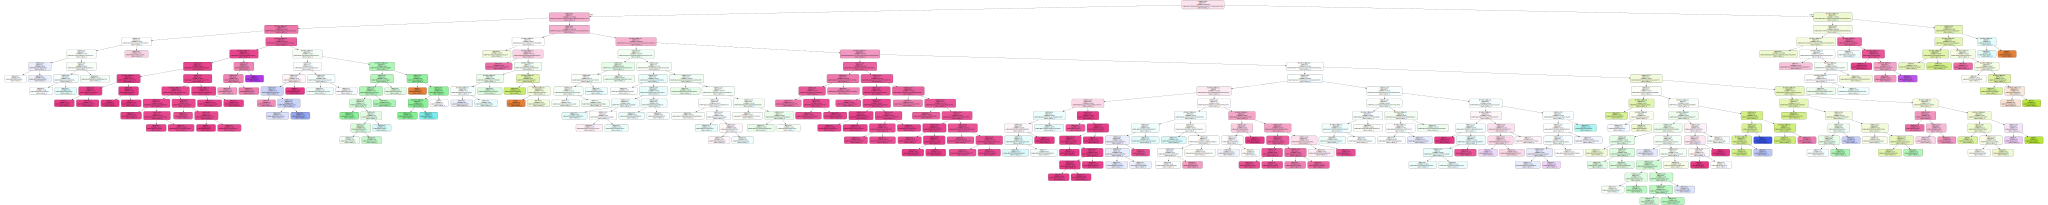

In [ ]:
draw_random_forest_tree(1)

Calculemos el accuracy

In [ ]:
predictions = clf.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train['shipment_days_byclass'] == predictions))/float(y_train.size)*100))

Accuracy: 27 


El accuracy que obtenemos es mucho más alto que con el linear y el polinomial.

Vamos a calcular las métricas definidas en el punto anterior, para eso vamos a restar lo que predice el modelo(predictions) con el valor real de los datos que sería en nuestro caso 'shipment_days_byclass'.

In [ ]:
new_metric = predictions - y_train['shipment_days_byclass']

Analicemos la métrica:

1) Si new_metric es igual a 0 es porque el pedido llegó el día prometido.

2) Si new_metric > 0 es porque predictions > y_train['shipment_days_byclass'] esto quiere decir que lo prometido es mayor a la cantidad de días real, por ende el pedido se demoró menos que el día prometido. Veamos un ejemplo si predictions es 5 e y_train da 3, es porque el pedido estaba prometido para el día 5 pero en lo real llegó el dia 3.

3) Si new_metric < 0 es porque  predictions < y_train['shipment_days_byclass'] siguiendo la misma lógica de arriba, podemos concluir que el pedido llegó después del día prometido.

4) La cantidad de pedidos la podemos ver con x_train.shape o y_train.shape.


In [ ]:
new_metric

0         1
1         1
2        -1
3         0
4         0
         ..
499990    0
499991    0
499992   -1
499994    1
499999    0
Name: shipment_days_byclass, Length: 321523, dtype: int64

In [ ]:
type(new_metric)

pandas.core.series.Series

In [ ]:
total_orders = new_metric.size
total_orders

321523

In [ ]:
df_train['new_metric'] = new_metric

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train.head(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le,date_created_only_date,date_visit_only_date,new_metric
0,SP,1039,SP,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,25,2019-03-10,2019-03-18,1
1,SP,3004,PB,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,14,2019-03-08,2019-03-18,1
2,SP,3262,RJ,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,18,2019-02-21,2019-03-01,-1
3,SP,12237,SP,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,25,2019-02-25,2019-03-07,0
4,SP,9350,AP,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,3,2019-02-15,2019-03-11,0


In [ ]:
count_ceros = df_train.loc[df_train['new_metric']==0]
count_ceros = count_ceros.shape[0]
count_ceros

176002

Obtenemos una cantidad de 176002 de pedidos, de los cuáles llegaron el día prometido.

In [ ]:
print ('Porcentaje de pedidos que llegaron el dia prometido: %f ' % (float(count_ceros)/float(total_orders))*100)

Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcentaje de pedidos que llegaron el dia prometido: 0.547401 Porcenta

Calculemos la métrica 2) porcentaje de pedidos que llegaron antes del día prometido:

In [ ]:
count_received_before_that_promise_date = df_train.loc[df_train['new_metric']>0]
count_received_before_that_promise_date = count_received_before_that_promise_date.shape[0]
count_received_before_that_promise_date

58259

Nos falta calcularlo sobre el total, por ende queda:

In [ ]:
print ('Porcentaje de pedidos que llegaron antes del dia prometido: %f ' % (float(count_received_before_that_promise_date)/float(total_orders))*100)

Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron antes del dia prometido: 0.181197 Porcentaje de pedidos que llegaron

Calculemos la métrica 3) porcentaje de pedidos que llegaron después del día prometido:

In [ ]:
count_received_after_that_promise_date = df_train.loc[df_train['new_metric']<0]
count_received_after_that_promise_date = count_received_after_that_promise_date.shape[0]
count_received_after_that_promise_date

87262

Nos falta calcularlo sobre el total, por ende queda:

In [ ]:
print ('Porcentaje de pedidos que llegaron después del dia prometido: %f ' % (float(count_received_after_that_promise_date)/float(total_orders))*100)

Porcentaje de pedidos que llegaron después del dia prometido: 0.271402 


Conclusiones:

La diferencia entre los modelos de este práctico con el anterior; que en el anterior obteníamos mejores accuracys.
Creemos que la performance disminuye (habría que calcular las métricas definidas en este práctico, en los clasificadores del práctico anterior).
En cuanto a las nuevas métricas definidas el modelo de esembling nos estaría dando bastante bien, sin mirar el accuracy. Es decir un 54% de los pedidos se está prometiendo que va a demorar una cantidad de días que coinciden con lo real.
Creemos que agregando alguna features más que sean relevantes para nuestra problemática se podría llegar a mejorar nuestra performance en estos clasificadores.
